In [1]:
#calculo
import numpy as np
import pandas as pd

#grafico
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def error_print(text):
    print("*"*50)
    print("ERROR:", text)
    print("*"*50)

In [3]:
class Analizer:
    def __init__(self, ruta='', sep=','):
        func_read = pd.read_csv if ruta.lower().endswith('.csv') else None
        if not func_read:
            error_print('archivo .csv no detectado')
            self.data = None
            return
            
        try:
            self.data = pd.read_csv(ruta, encoding= "ISO-8859-1", sep=sep)
        except:
            error_print('verifique ubicacion de archvio')
            self.data = None
            return

    def null_data(func):
        def proccess(self, *args, **kwargs):
            if self.data is None:
                error_print('data no extraida')
                return
            return func(self, *args, **kwargs)
        return proccess

    
    @null_data
    def null_verificator(self):        
        if self.data.isnull().any().any():
            view_info = pd.DataFrame(
                pd.concat(
                    [self.data.isnull().any(), 
                     self.data.isnull().sum(),
                     self.data.dtypes], 
                    axis=1)
            )
            view_info.columns = ['Nulos', 'Cantidad', 'Tipo Col']
            return view_info
        else:
            return "DATA LIMPIA DE NULOS"
    
    @null_data
    def percentil_verificator(self, cols=[]):
        datus = self.data.copy()
        list_percentil = [0,1,3,5,10,20,30,50,60,70,80,90,95,97,99,100]
        for col in cols:
            plt.plot(
                list_percentil,
                np.nanpercentile(datus[col], list_percentil),
                label=col
            )
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        df_datus = pd.concat(
            [ 
                pd.Series(np.nanpercentile(datus[col], list_percentil),
                          index=list_percentil) 
                for col in cols
            ],
            axis=1
        )
        df_datus.columns = cols
        return df_datus.T

In [4]:
train_analisis = Analizer("data/Train.csv")

In [5]:
train_analisis.null_verificator()

,Nulos,Cantidad,Tipo Col
Patient_ID,False,0,int64
Health_Camp_ID,False,0,int64
Registration_Date,True,323,object
Var1,False,0,int64
Var2,False,0,int64
Var3,False,0,int64
Var4,False,0,int64
Var5,False,0,int64


In [6]:
train_analisis.data.shape

(58532, 8)

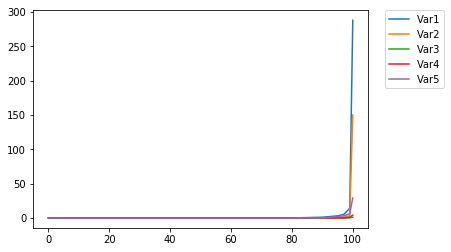

,0,1,3,5,10,20,30,50,60,70,80,90,95,97,99,100
Var1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,14.0,288.0
Var2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,150.0
Var3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Var4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
Var5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,6.0,29.0


In [6]:
train_analisis.percentil_verificator(['Var1','Var2','Var3','Var4','Var5'])